In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

<a id="00"></a>
# Building the Linear Model

The purpose of this notebook is to take a methodological approach to building the Logistic Regression Model for the Covid-19 data, which was thoroughly explored in the EDA notebook. In addition, we will use machine learning techniques to evaluate the model as well as use the model to make predictions about patient mortality as a result of Covid-19 infection.
1. [Load the data](#0)
2. [Mean Model (null model)](#1)
3. [Building the Linear Model](#2)
4. [Evaluating the Final Model](#3)
    - [Cross Validation](#3a)
    - [Learning Curves](#3b)
5. [Describe the Linear Model](#4)
6. [Using the Linear Model](#5)


In [3]:
import models
import sqlite3
import pandas as pd
from tabulate import tabulate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy
from collections import defaultdict

sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

In [4]:
np.random.seed(23671489)
random.seed(4629378)

<a id="0"></a>
## Load the Data

Many of the decisions for the data are based on result from ETL and EDA, including columns and rows to drop from the data set.

First, we can pull the necessary data from the database as follows, similar to the query from ETL:

In [5]:
con = sqlite3.connect('data.db')

In [6]:
query = """
SELECT * 
FROM patient
INNER JOIN blood on blood.patient_id = patient.id
"""

df = pd.read_sql_query(query, con)

Next, we implement any basic transformations or drop any columns that aren't needed for analysis:

In [7]:
df = df.drop(['id', 'patient_id', 'ferritin', 'glucose'], axis=1) #get rid of id columns and columns with half missing values or more

df['temp_F'] = ((9/5) * df.temperature) + 32 #convert celsius to fahrenheit

x = pd.DataFrame(df.iloc[:, 4:8]) #undo dummy variables in a new column
df['race'] = x.idxmax(axis=1)

Next, we can drop rows according to our results in EDA where patients were missing multiple values across many variables. This includes instances where blood panel results are missing so we do not have any numerical data for the patient, or values are unrealistic according to domain knowledge which may be an error:

In [8]:
data = df[((df.temp_F >= 95) & (df.temp_F <= 108)) & (df.mean_arterial_pressure != 0) & (df.aspartate_aminotransferase != 0)]

Since we are using **logistic regression**, scaling the data is not favorable since it will affect the interpretability of the model. Therefore, KNNImputer or any distance based methods for missing value imputation may not be ideal. Let's see how many values are still missing from significant variables, according to EDA:

In [9]:
col = ['oxygen_saturation', 'sodium', 'white_blood_cell', 'platelets', 'lymphocytes']
data[col] = data[col].replace(0, np.NaN)
pd.DataFrame(data.isnull().sum())

,0
length_of_stay,0
age,0
death,0
severity,0
black,0
white,0
asian,0
latino,0
myocardial_infarction,0
peripheral_vascular_disease,0


We have less that ~50 missing values after removing the rows that were missing blood panel results or had errors for the patient data. Therefore, we are better off dropping these rows, as well, since we will still have over 4000 patients in our sample. 

In [10]:
data = data.dropna()

Finally, we can make sure our data was loaded correctly:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175 entries, 0 to 4709
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   length_of_stay                         4175 non-null   int64  
 1   age                                    4175 non-null   int64  
 2   death                                  4175 non-null   int64  
 3   severity                               4175 non-null   int64  
 4   black                                  4175 non-null   int64  
 5   white                                  4175 non-null   int64  
 6   asian                                  4175 non-null   int64  
 7   latino                                 4175 non-null   int64  
 8   myocardial_infarction                  4175 non-null   int64  
 9   peripheral_vascular_disease            4175 non-null   int64  
 10  congestive_heart_disease               4175 non-null   int64  
 11  card

In [12]:
data.head()

,length_of_stay,age,death,severity,black,white,asian,latino,myocardial_infarction,peripheral_vascular_disease,...,aspartate_aminotransferase,alanine_aminotransferase,white_blood_cell,lymphocytes,interleukin6,C_reactive_protein,procalcitonin,troponin,temp_F,race
0,1,89,0,3,0,0,0,0,0,0,...,26.0000,14.0000,5.6000,1.4000,0.0000,0.4999,0.0000,0.0100,98.4000,black
1,2,67,1,7,0,1,0,0,0,1,...,85.0000,32.0000,12.2000,0.3000,0.0000,14.9000,0.6000,1.2000,97.4000,white
2,2,94,1,7,0,1,0,0,0,1,...,32.0000,18.0000,6.1000,0.5000,324.1000,33.9000,1.2000,0.0000,102.6000,white
3,15,72,0,9,1,0,0,0,1,0,...,44.0000,17.0000,3.7000,0.5000,0.0000,18.4000,7.3000,0.0500,102.0000,black
4,9,71,0,7,1,0,0,0,0,0,...,38.0000,28.0000,5.7000,1.4000,39.4000,11.6000,0.0000,0.0100,100.5000,black


For future use, we can store this fully cleaned and transformed data into a new table in our database:

In [13]:
cursor = con.cursor()

query = """
DROP TABLE IF EXISTS Covid_19_patient_data
"""

cursor.execute(query)
con.commit()

In [14]:
data.to_sql(name='Covid_19_patient_data', con=con);

<a id="1"></a>
## Mean (null) Model 

[Back to Contents](#00)

The null model and the error rate are as follows:

In [15]:
mean = np.mean(data.death)
print("P(death=1) = {0:.2f} ({1:.2f})".format(mean, 1-mean))

P(death=1) = 0.24 (0.76)


The null model is that $P(death = 1) = 0.24$ which leads to an error rate of 76%. 

<a id="2"></a>
## Building the Linear Model

[Back to Contents](#00)

Before attempting an "all-in" model, we will summarize the results from EDA. We started with over 40 variables and narrowed it down to 22 variables that either contained enough data or showed some level of correlation with the target variable, `death`. 

Before summarizing all of the relationships, let's look at all the relavent correlation coefficients in our data set:

In [16]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [17]:
correlations(data, 'death', ["age", "oxygen_saturation", "temp_F", "mean_arterial_pressure", \
            "D_dimer", "platelets", "creatinine", "sodium", "aspartate_aminotransferase", "alanine_aminotransferase", "white_blood_cell", \
            "interleukin6", "C_reactive_protein", "procalcitonin", "troponin", "length_of_stay"])

,feature,r,rho
0,age,0.2906,0.2998
1,oxygen_saturation,-0.2188,-0.1771
2,temp_F,0.0184,0.0154
3,mean_arterial_pressure,-0.3715,-0.3048
4,D_dimer,0.1777,0.1245
5,platelets,-0.0803,-0.0883
6,creatinine,0.1385,0.2431
7,sodium,0.1205,0.0832
8,aspartate_aminotransferase,0.0952,0.1654
9,alanine_aminotransferase,0.0555,0.0198


Using these correlation coefficients, we can summarize the relationships found in EDA as follows:

**Death vs. Age**: There is a medium linear relationship, as indicated by the Pearson coefficient of 0.29, and a slightly stronger nonlinear relationship, as indicated by the Spearman coefficient of 0.30. Patients who died from Covid-19 were older than patients who survived.

**Death vs. Race**: There does not seem to be an obvious relationship between race and death. Black and latino individuals made up a majority of patients in the data set, but the proportion of individuals who died from Covid-19 are pretty similar (about one fourth for all groups).

**Death vs. myocardial infarction**: There does not seem to be a significant relationship since one fourth of patients who had myocardial infarctions died from Covid-19 and one fourth of patients who did not have myocardial infarctions died from Covid-19. 

**Death vs. peripheral vascular disease(PVD)**: There does not seem to be a significant relationship since about 18% of patients who had either Grade I or Grade II PVD died from Covid-19 and one fourth of patients without PVD died from Covid-19.  

**Death vs. congestive heart disease**: There seems to be a weak relationships since 27% of patients with congestive heart failure died from Covid-19 and 23% of patients without congestive heart failure died from Covid-19. 

**Death vs. chronic obstructive pulmonary disease(COPD)**: There is a significant relationship between COPD and patient outcome from Covid-19. About one third of patients with COPD died from Covid-19 compared to about one fourth of patients without COPD who died from Covid-19.

**Death vs. diabetes mellitus simple**: There does not seem to be a significant relationship, since one fourth of patients with and without diabetes died from Covid-19.

**Death vs. renal disease**: There is a significant relationship between renal disease and poor patient outcome from Covid-19, since one third of patients with renal disease died from Covid-19 and only one fourth of patients without renal disease died from Covid-19. 

**Death vs. central nervous system disease(CNS)**: There is a significant relationship between CNS diseases and poor patient outcome from Covid-19. About one third of patients with a CNS disease died from Covid-19, compared to less than a fourth of patients who did not have a CNS disease and died from Covid-19.

**Death vs. stroke**: There is a very significant relationship between strokes and patient outcomes from Covid-19, since half of patients who suffered from a stroke died from Covid-19, compared to one fourth of patients who did not suffer from a stroke who died. There is an issue, however, since only about 50 patients in the data-set had a stroke which is a small sample size.

**Death vs. seizure**: There is a relationship since about one third of patients who suffered from seizures died from Covid-19, compared to about one fourth of patients who did not suffer from seizures and died from Covid-19. 

**Death vs. oxygen saturation**: There is a negative linear relationship, as indicated by the Pearsons coefficent of -0.22, and negative nonlinear relationship, as indicated by the Spearmans coefficient of -0.18. Patients who died from Covid-19 had a lower oxygen saturation level on average that was below the normal range compared to patients who survived.

**Death vs. temperature**: The relationship between poor patient outcomes as a result of Covid-19 and temperature is very weak, which is expected since temperature was not a required symptom since many patients did not develop fevers. Both the Pearson and Spearman coefficients are only 0.02, which implies a very weak relationship. 

**Death vs. mean arterial pressure(MAP)**: There is a significant, negative linear relationship, as indicated by the Pearson coefficient of -0.38, and a significant, negative nonlinear relationship, as indicated by the Spearman coefficient of -0.31. Patient's who died from Covid-19 had a lower MAP level, on average. 

**Death vs. D-dimer**: There is a somewhat significant linear relationship, as indicated by the Pearson's coefficient of 0.18, and a somewhat significant nonlinear relationship, as indicated by the Spearmans coefficient of 0.13. Patients who died from Covid-19 had a higher D-dimer level, on average. 

**Death vs. platelets**: There seems to be a somewhat significant relationship between patient outcome and platelet counts, where patients who died from Covid-19 had lower platelets counts. There is a somewhat significant, negative, linear relationship, as indicated by the Pearson's coefficient of -0.08, and a somewhat significant, negative, nonlinear relationship, as indicated by the Spearmans coefficient of -0.09.

**Death vs. creatinine**: There is a somewhat weak linear relationship (r = 0.13) and a stronger nonlinear relationship (rho = 0.24). Patients who died from Covid-19 had a higher creatinine level, on average, but the distribution of creatinine levels for patients who survived is more dispersed. Therefore, creatinine may be a good candidate for an *interaction term*. 

**Death vs. Sodium**: There is a somewhat significant linear relationship between sodium and death from Covid-19 (r = 0.12), and a less significant nonlinear relationship (rho = 0.08). Patients who died from Covid-19 had higher sodium levels, on average. 

**Death vs. Asparate aminotransferase**: There is a somewhat significant linear relationship (r = 0.09) and a stronger nonlinear relationship (rho = 0.17) between AST and death. Patients who died from Covid-19 had higher levels of AST than patients who survived. 

**Death vs. Alanine aminotransferase**: There is a weak linear relationship (r = 0.05) and a weaker nonlinear relationship (rho = 0.02) between ALT and death. Patients who died from Covid-19 had higher levels of ALT than patients who survived, but it is not as significant as AST. 

**Death vs. White blood cells**: There is a weak linear relationship (r = 0.06) and a stronger nonlinear relationship (rho = 0.09) between WBC counts and death. Patients who died from Covid-19 had more elevated WBC counts compared to patients who survived, but both mean WBC counts were within the normal range. 

**Death vs. Interleukin-6**: There is a weak linear relationship (r = 0.04) and a stronger nonlinear relationship (rho = 0.07) between IL-6 and death. When we removed the three extreme values, the Pearson's coefficent increased to 0.09. Patients who died from Covid-19 had a much higher IL-6 level, on average, compared to patients who survived.

**Death vs. C-reactive Protein**: There is a significant linear relationship, as indicated by the Pearson's coefficient of 0.22, and a slightly weaker nonlinear relationship, as indicated by the Spearman's coefficient of 0.18. Patients who died from Covid-19 had higher c-reactive protein levels compared to patients who survived.

**Death vs. Procalcitonin**: There is a medium to weak relationship (r = 0.17) and a slightly stronger nonlinear relationship (rho = 0.19) between death and procalcitonin. Patients who died from Covid-19 had more elevated levels of procalcitonin compared to patients who survived. 

**Death vs. Troponin**: There is a medium to weak linear relationship (r = 0.12) and a stronger nonlinear relationship (rho = 0.24) between troponin and death. Patients who died from Covid-19 had higher troponin levels, on average. 

**Death vs. Length of Stay**: There is a medium to weak linear relationship (r = 0.14) and a stronger nonlinear relationship (rho = 0.16) between the length of the hospital stay and death. Patients who died from Covid-19 stayed in the hospital longer than patients who survived, on average. 


Based on the exploration during EDA, we may not need all of these variables, such as race. This is especially the case for some of the categorical variables since many of the blood panel results are used to diagnose these conditions. To start, we will try an all in model so we may reference back to it as we make adjustments. 

In [18]:
model1 =  "death ~ age + myocardial_infarction + peripheral_vascular_disease + congestive_heart_disease + chronic_obstructive_pulmonary_disease \
                + all_central_nervous_system_disease + diabetes_mellitus_simple + renal_disease + stroke + seizure + oxygen_saturation + temp_F + mean_arterial_pressure \
                + D_dimer + platelets + creatinine + sodium + aspartate_aminotransferase + alanine_aminotransferase + white_blood_cell \
                + interleukin6 + C_reactive_protein + procalcitonin + troponin + length_of_stay"
result1 = models.bootstrap_logistic_regression(model1, data)
models.describe_bootstrap_lgr(result1, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00001,-0.00034,0.00023,0.50000
age,$\beta_{1}$,0.05061,0.04580,0.05789,0.01265
myocardial_infarction,$\beta_{2}$,-0.00004,-0.00451,0.00221,-0.00001
peripheral_vascular_disease,$\beta_{3}$,-0.00412,-0.02529,-0.00187,-0.00103
congestive_heart_disease,$\beta_{4}$,0.00035,-0.00316,0.00516,0.00009
chronic_obstructive_pulmonary_disease,$\beta_{5}$,0.00034,-0.00161,0.00577,0.00009
all_central_nervous_system_disease,$\beta_{6}$,0.00210,0.00055,0.01623,0.00053
diabetes_mellitus_simple,$\beta_{7}$,-0.00023,-0.00817,0.00216,-0.00006
renal_disease,$\beta_{8}$,0.00196,0.00011,0.01464,0.00049


The error rate is 17.73% and the pseudo $R^2$ is 0.29, which is *okay*, but maybe we can do better. We can evaluate the coefficients as follows:

- **age:** For every one year increase in a patients age, the *log odds* of death increases by 0.05061. The coefficient sign is *expected* and is strongly supported by the 95% BCI. 

- **myocardial_infarction:** When a patient has myocardial infarction, the *log odds* of death decreases by -0.00004. The coefficient sign is *unexpected* and the 95% BCI includes zero. Therefore, we can drop this variable from our model since there is greater than a 50% chance that the coefficient is zero, although the evidence is not strong.

- **peripheral_vascular_disease:** When a patient has PVD, the *log odds* of death decreases by -0.00412. This coefficient sign is *expected*, according to results from EDA, and is strongly supported by the 95% BCI. According to domain knowledge, however, the sign is not expected and the variable in general was troublesome for this reason. I included it in the model to also confirm if the coefficient would *actually* be negative. Since it is, we will drop this variable from the model since it does not align with domain knowledge and trends seen in other related variables. 

- **congestive_heart_disease:** When a patient has congestive heart disease, the *log odds* of death increases by 0.00035. The coefficient sign is *expected* and has mixed support from the data based on the 95% credible interval. 

- **chronic_obstructive_pulmonary_disease:** When a patient has COPD, the *log odds* of death increases by 0.00034. The coefficient sign is *expected* and has mixed support from the data. 

- **all_central_nervous_system_disease:** When a patient has a CNS disease, the *log odds* of death increases by 0.00210. The coefficient sign is *expected* and has strong support from the data. 

- **diabetes_mellitus_simple:** When a patient has diabetes, the *log odds* of death decreases by -0.00023. The coefficient sign is *unexpected* and has mixed support from the data since the 95% BCI includes zero. Therefore, we can drop this variable from our model.

- **renal_disease:** When a patient has renal disease, the *log odds* of death increases by 0.00196. The coefficient sign is *expected* and is strongly supported by the 95% BCI. 

- **stroke:** When a patient has had a stroke, the *log odds* of death increases by 0.00070. The coefficient sign is *expected* and has strong support from the data.

- **seizure:** When a patient has had a seizure, the *log odds* of death increase by 0.00019. The coefficient sign is *expected* and has mixed support from the data.

- **oxygen_saturation:** When the oxygen saturation increases by one unit, the *log odds* of death decreases by -0.03848. The coefficient sign is *expected* and is strongly supported by the data.

- **temp_F:** When the temperature increases by one unit, the *log odds* of death increases by 0.00629. The coefficient sign is *expected* and has mixed support from the data. 

- **mean_arterial_pressure:** For every one unit increase in MAP, the *log odds* of death decreases by -0.04463. The coefficient sign is *expected* and is strongly supported by the data. *(remember that patients who died from Covid-19 had **low** MAP levels compared to patients who survived)* 

- **D_dimer:** For every one unit increase in the D-dimer level, the *log odds* of death increases by 0.01366. The coefficient sign is *expected* and has mixed support from the data.

- **platelets:** For every one unit increase in the platelet counts, the *log odds* of death decrease by -0.00193. The coefficient sign is *expected* and is strongly supported by the data.

- **creatinine:** For every one unit increase in the creatinine level, the *log odds* of death increases by 0.01915. The coefficient sign is *expected* and is strongly supported by the data.

- **sodium:** For every one unit increase in the sodium level, the *log odds* of death increases by 0.01286. The coefficient sign is *expected* and is strongly supported by the data.

- **aspartate_aminotransferase:** For every one unit increase in the AST level, the *log odds* of death increases by 0.00067. The coefficient sign is *expected* and is strongly supported by the data, based on the 95% BCI.

- **alanine_aminotransferase:** For every one unit increase in the ALT level, the *log odds* of death increases by 0.00053. The coefficient sign is *expected* and has mixed support from the data.

- **white_blood_cell:** For every one unit increase in the WBC counts, the *log odds* of death increases by 0.00180. The coefficient sign is *expected* and has mixed support from the data.

- **interleukin6:** For every one unit increase in the IL-6 level, the *log odds* of death increases by 0.000001 (I checked for this very small value by increasing the significant digits but reverted back since it becomes hard to read the model results with so many digits). The coefficient sign is *expected* and has mixed support from the data.

- **C_reactive_protein:** For every one unit increase in the c-reactive protein level, the *log odds* of death increases by 0.01898. The coefficient sign is *expected* and is strongly supported by the data, based on the 95% BCI.

- **procalcitonin:** For every one unit increase in the procalcitonin level, the *log odds* of death increases by 0.03190. The coefficient sign is *expected* and is strongly supported by the data.

- **troponin:** For every one unit increase in the troponin level, the *log odds* of death increases by 0.00288. The coefficient sign is *expected* and is strongly supported by the data.

- **length_of_stay:** For addition day that a patient stays in the hospital for Covid-19, the *log odds* of death increases by 0.03426. The coefficient sign is *expected* and is strongly supported by the data.

Before assessing a new model without the variables we indicated we would drop, we can look at the binary confusion matrix as well as the metrics for evaluating classification models.

In [19]:
def binary_confusion_matrix(result, metrics = False):
    tp = 0; tn = 0; fn = 0; fp = 0
    for y, y_hat in zip(result["y"], result["y_hat"]):
        if y == 0 and y_hat == 0:
            tn += 1
        elif y == 0 and y_hat == 1:
            fp += 1
        elif y == 1 and y_hat == 1:
            tp += 1
        else:
            fn += 1
    if metrics is True:
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        error_rate = (fp + fn) / (tp + fp + fn + tn)
        sensitivity = tp/(tp + fn)
        false_neg = 1 - sensitivity
        specificity = tn/(tn + fp)
        false_pos = 1 - specificity
        precision = tp/(tp + fp) #positive prediciton value 
        f1 = (2 * tp) / ((2 * tp) + fp + fn)
        return tabulate([["Accuracy", accuracy], ["Error Rate", error_rate], ["Sensitivity", sensitivity],
                         ["False Negative", false_neg] ,["Specificity", specificity],["False Positive", false_pos],
                         ["Precision", precision], ["F1", f1]], headers = ["Metrics", "Result"],tablefmt='html')
    else:
        return tabulate([["Predicted 1", tp, fp], ["Predicted 0", fn, tn]], headers=["", "Actual 1", "Actual 0"], tablefmt='html')

In [20]:
binary_confusion_matrix(result1)

,Actual 1,Actual 0
Predicted 1,432,169
Predicted 0,571,3003


The model seems to classify negative cases pretty efficiently, but has an issue with false negatives. Let's look at the metrics based on these classification counts:

In [21]:
binary_confusion_matrix(result1, metrics = True)

Metrics,Result
Accuracy,0.822754
Error Rate,0.177246
Sensitivity,0.430708
False Negative,0.569292
Specificity,0.946721
False Positive,0.0532787
Precision,0.718802
F1,0.538653


As stated above, the false positive rate is very low, at only 5.32%, but the false negative rate is pretty high, at 56.92%. The precision of the model is relatively good, at 71.88%.

Let's try generating a model without the variables that we specified we would drop:

In [22]:
model2 =  "death ~ age + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease \
                + renal_disease + stroke + seizure + temp_F + oxygen_saturation + mean_arterial_pressure \
                + D_dimer + platelets + creatinine + sodium + aspartate_aminotransferase + alanine_aminotransferase + white_blood_cell \
                + interleukin6 + C_reactive_protein + procalcitonin + troponin + length_of_stay"
result2 = models.bootstrap_logistic_regression(model2, data)
models.describe_bootstrap_lgr(result2, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00002,-0.00021,0.00017,0.50000
age,$\beta_{1}$,0.05047,0.04368,0.05769,0.01262
congestive_heart_disease,$\beta_{2}$,0.00027,-0.00128,0.00542,0.00007
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.00022,-0.00108,0.00418,0.00006
all_central_nervous_system_disease,$\beta_{4}$,0.00145,0.00081,0.01414,0.00036
renal_disease,$\beta_{5}$,0.00124,0.00039,0.01210,0.00031
stroke,$\beta_{6}$,0.00045,0.00020,0.00523,0.00011
seizure,$\beta_{7}$,0.00012,-0.00035,0.00156,0.00003
temp_F,$\beta_{8}$,0.00500,-0.00613,0.02644,0.00125


The error rate is 17.82%, which is a slight improvement from the previous model, and the pseudo $R^2$ is unchanged at 0.29. We can evaluate the coefficients as follows:

- **age:** For every one year increase in a patients age, the *log odds* of death increases by 0.05047. The coefficient sign is *expected* and is strongly supported by the 95% BCI. 

- **congestive_heart_disease:** When a patient has congestive heart disease, the *log odds* of death increases by 0.00027. The coefficient sign is *expected* and has mixed support from the data based on the 95% credible interval. 

- **chronic_obstructive_pulmonary_disease:** When a patient has COPD, the *log odds* of death increases by 0.00022. The coefficient sign is *expected* and has mixed support from the data. 

- **all_central_nervous_system_disease:** When a patient has a CNS disease, the *log odds* of death increases by 0.00145. The coefficient sign is *expected* and has strong support from the data.

- **renal_disease:** When a patient has renal disease, the *log odds* of death increases by 0.00124. The coefficient sign is *expected* and is strongly supported by the 95% BCI. 

- **stroke:** When a patient has had a stroke, the *log odds* of death increases by 0.00045. The coefficient sign is *expected* and has strong support from the data.

- **seizure:** When a patient has had a seizure, the *log odds* of death increase by 0.00012. The coefficient sign is *expected* and has mixed support from the data.

- **temp_F:** When the temperature increases by one unit, the *log odds* of death increases by 0.00500. The coefficient sign is *expected* and has mixed support from the data.

- **oxygen_saturation:** When the oxygen saturation increases by one unit, the *log odds* of death decreases by -0.04188. The coefficient sign is *expected* and is strongly supported by the data.

- **mean_arterial_pressure:** For every one unit increase in MAP, the *log odds* of death decreases by -0.04455. The coefficient sign is *expected* and is strongly supported by the data. 

- **D_dimer:** For every one unit increase in the D-dimer level, the *log odds* of death increases by 0.01463. The coefficient sign is *expected* and has mixed support from the data.

- **platelets:** For every one unit increase in the platelet counts, the *log odds* of death decrease by -0.00208. The coefficient sign is *expected* and is strongly supported by the data.

- **creatinine:** For every one unit increase in the creatinine level, the *log odds* of death increases by 0.01398. The coefficient sign is *expected* and is strongly supported by the data.

- **sodium:** For every one unit increase in the sodium level, the *log odds* of death increases by 0.01608. The coefficient sign is *expected* and is strongly supported by the data.

- **aspartate_aminotransferase:** For every one unit increase in the AST level, the *log odds* of death increases by 0.00078. The coefficient sign is *expected* and is strongly supported by the data, based on the 95% BCI.

- **alanine_aminotransferase:** For every one unit increase in the ALT level, the *log odds* of death increases by 0.00035. The coefficient sign is *expected* and has mixed support from the data.

- **white_blood_cell:** For every one unit increase in the WBC counts, the *log odds* of death increases by 0.00231. The coefficient sign is *expected* and has mixed support from the data.

- **interleukin6:** For every one unit increase in the IL-6 level, the *log odds* of death increases by 0.000001. The coefficient sign is *expected* and has mixed support from the data.

- **C_reactive_protein:** For every one unit increase in the c-reactive protein level, the *log odds* of death increases by 0.01898. The coefficient sign is *expected* and is strongly supported by the data, based on the 95% BCI.

- **procalcitonin:** For every one unit increase in the procalcitonin level, the *log odds* of death increases by 0.03148. The coefficient sign is *expected* and is strongly supported by the data.

- **troponin:** For every one unit increase in the troponin level, the *log odds* of death increases by 0.00184. The coefficient sign is *expected* and is strongly supported by the data.

- **length_of_stay:** For addition day that a patient stays in the hospital for Covid-19, the *log odds* of death increases by 0.03642. The coefficient sign is *expected* and is strongly supported by the data.

Overall, none of the coefficient's changed significantly from the previous model. Next, we can look at the binary confusion matrix as well as the metrics for evaluating classification models.

In [23]:
binary_confusion_matrix(result2)

,Actual 1,Actual 0
Predicted 1,429,170
Predicted 0,574,3002


Compared to model #1, there isn't a significant difference in the confusion matrix. We correctly classify a few more cases where patients died and misclassify a few more cases where patients survived, so the false positive and false negative rate converged a bit. Let's look at the metrics:

In [24]:
binary_confusion_matrix(result2, metrics = True)

Metrics,Result
Accuracy,0.821796
Error Rate,0.178204
Sensitivity,0.427717
False Negative,0.572283
Specificity,0.946406
False Positive,0.0535939
Precision,0.716194
F1,0.535581


The accuracy increased slightly, which is expected since the error rate decreased. The false negative rate is unchanged at 0.57 and the false positive rate increased from 0.0532 to 0.0536, which is negligible. The precision decreased from 0.719 to about 0.716, which again, is a bit negligible. The model seems a bit better after dropping the variables but it is not significant.

Let's try mean centering all of the numerical variables to see if this improves the sensitivity of the model, in order to reduce instances of false negatives.

In [25]:
def mean_center( df, variable):
    x_bar = df[ variable].mean()
    scaled_variable = df[ variable] - x_bar
    df[ variable + "_cen"] = scaled_variable

In [26]:
var_to_center = ["age", "oxygen_saturation", "mean_arterial_pressure", "D_dimer", "platelets", "creatinine", "sodium", 
                 "aspartate_aminotransferase", "alanine_aminotransferase", "white_blood_cell", "interleukin6", "C_reactive_protein", 
                 "procalcitonin", "troponin", "length_of_stay"]

for var in var_to_center:
    mean_center(data, var)

In [27]:
data.head()

,length_of_stay,age,death,severity,black,white,asian,latino,myocardial_infarction,peripheral_vascular_disease,...,creatinine_cen,sodium_cen,aspartate_aminotransferase_cen,alanine_aminotransferase_cen,white_blood_cell_cen,interleukin6_cen,C_reactive_protein_cen,procalcitonin_cen,troponin_cen,length_of_stay_cen
0,1,89,0,3,0,0,0,0,0,0,...,-1.2882,-3.0767,-38.5925,-30.8902,-3.1687,-123.6834,-10.3102,-1.6078,-0.0429,-6.0925
1,2,67,1,7,0,1,0,0,0,1,...,7.2118,-1.0767,20.4075,-12.8902,3.4313,-123.6834,4.0899,-1.0078,1.1471,-5.0925
2,2,94,1,7,0,1,0,0,0,1,...,1.4718,1.9233,-32.5925,-26.8902,-2.6687,200.4166,23.0899,-0.4078,-0.0529,-5.0925
3,15,72,0,9,1,0,0,0,1,0,...,6.3118,-6.0767,-20.5925,-27.8902,-5.0687,-123.6834,7.5899,5.6922,-0.0029,7.9075
4,9,71,0,7,1,0,0,0,0,0,...,0.6118,10.9233,-26.5925,-16.8902,-3.0687,-84.2834,0.7899,-1.6078,-0.0429,1.9075


Let's try using this these mean centered numerical variables in the model to see if the error rate decreases and the specificity increases.

In [28]:
model3 =  "death ~ age_cen + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease \
                + renal_disease + stroke + seizure + oxygen_saturation_cen + mean_arterial_pressure_cen \
                + D_dimer_cen + platelets_cen + creatinine_cen + sodium_cen + aspartate_aminotransferase_cen + alanine_aminotransferase_cen + white_blood_cell_cen \
                + interleukin6_cen + C_reactive_protein_cen + procalcitonin_cen + troponin_cen + length_of_stay_cen"
result3 = models.bootstrap_logistic_regression(model3, data)
models.describe_bootstrap_lgr(result3, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,-0.56183,-1.55144,-0.07694,0.36312
age_cen,$\beta_{1}$,0.02200,0.02157,0.05744,0.00550
congestive_heart_disease,$\beta_{2}$,-0.06140,-0.18604,-0.00871,-0.01535
chronic_obstructive_pulmonary_disease,$\beta_{3}$,-0.02926,-0.09863,-0.00393,-0.00731
all_central_nervous_system_disease,$\beta_{4}$,-0.05668,-0.16226,-0.00824,-0.01417
renal_disease,$\beta_{5}$,-0.08513,-0.22847,-0.01211,-0.02128
stroke,$\beta_{6}$,-0.00172,-0.00715,0.02724,-0.00043
seizure,$\beta_{7}$,-0.00360,-0.01874,-0.00011,-0.00090
oxygen_saturation_cen,$\beta_{8}$,-0.02025,-0.07546,-0.02115,-0.00506


Mean centering worsens the model, which is evident in the increase error rate of 19.26% and the decreased pseudo $R^2$ value of 0.16. In addition, many of the coefficients are now unexpected signs with 95% BCI's that would result in variable removal, even though EDA revealed that the coefficients were significant. We will look at the binary confusion matrix and the classification metrics, but we will likely not use this model or mean centering for this data. 

In [29]:
binary_confusion_matrix(result3)

,Actual 1,Actual 0
Predicted 1,573,374
Predicted 0,430,2798


Compared to model #2, we have more true positives and more false negatives. However, the increase in false negatives is more substantial than the increase in true positives. Let's look at the metrics:

In [30]:
binary_confusion_matrix(result3, metrics=True)

Metrics,Result
Accuracy,0.807425
Error Rate,0.192575
Sensitivity,0.571286
False Negative,0.428714
Specificity,0.882093
False Positive,0.117907
Precision,0.605069
F1,0.587692


The false positive rate went from 0.05 to 0.12 and the false negative rate went from 0.57 to 0.43, which aligns with our observations from the confusion matrix. The precision decreased from 0.72 to 0.61, the specificity decreased from 0.95 to 0.88, and the sensitivity increased from 0.43 to 0.57. Overall, the model is *slightly* better at identifying positive cases but has a more significant decrease in performance when identifying negative cases. 

Instead of mean centering, we can try to implement interaction terms or variable transformations. Several variables, such as D-dimer, interleukin6, c-reactive protein, procalcitonin, and troponin, **can** be zero, so log transformations on all numerical variables would not work. The same is true for square root transformations. 

A few of the variables did have a stronger nonlinear relationship with `death` which could be due to either a needed transformation or a missing interaction term. These variables are `age`, `platelets`, `creatinine`, `aspartate_aminotransferase`, `white_blood_cell`, `interleukin6`, `procalcitonin`, `troponin`, and `length_of_stay`. Let's try squaring age and the length of stay variables and creating a new variable from AST and ALT to form the AST/ALT ratio [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3609680/#:~:text=A%20normal%20AST%3AALT%20ratio,and%20%3E2%20in%2070%25.&text=AST%3AALT%20scores%20%3E2%20are,more%20suggestive%20of%20NAFLD%2FNASH.) to see if the model performs better:

In [31]:
data['age_sq'] = data['age'] ** 2
data['LOS_sq'] = data['length_of_stay'] ** 2

data['AST_ALT'] = data['aspartate_aminotransferase'] / data ['alanine_aminotransferase']

In [32]:
model4 =  "death ~ age_sq + congestive_heart_disease + chronic_obstructive_pulmonary_disease +all_central_nervous_system_disease \
                + renal_disease + stroke + seizure + oxygen_saturation + mean_arterial_pressure \
                + D_dimer + platelets + creatinine + sodium + AST_ALT + white_blood_cell \
                + interleukin6 + C_reactive_protein + procalcitonin + troponin + LOS_sq"

result4 = models.bootstrap_logistic_regression(model4, data)
models.describe_bootstrap_lgr(result4, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00022,0.00006,0.00031,0.50005
age_sq,$\beta_{1}$,0.00038,0.00033,0.00041,0.00009
congestive_heart_disease,$\beta_{2}$,0.00030,-0.00034,0.00098,0.00007
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.00019,-0.00035,0.00070,0.00005
all_central_nervous_system_disease,$\beta_{4}$,0.00118,0.00013,0.00195,0.00030
renal_disease,$\beta_{5}$,0.00128,0.00012,0.00183,0.00032
stroke,$\beta_{6}$,0.00044,0.00010,0.00072,0.00011
seizure,$\beta_{7}$,0.00012,-0.00006,0.00028,0.00003
oxygen_saturation,$\beta_{8}$,-0.03622,-0.04384,-0.02393,-0.00906


The error rate is a bit greater at 17.84% and the pseudo $R^2$ is lower at 0.28. We can evaluate the coefficients that have major changes as follows:

- **D_dimer:** For every one unit increase in the D-dimer level, the *log odds* of death increases by 0.01532. The coefficient sign is *expected* and has now has strong support from the 95% BCI.

- **AST_ALT:** For every one unit increase in the AST:ALT ratio, the *log odds* of death increases by 0.01037. The coefficient sign is *expected* and has strong support from the 95% BCI.

The squared age and length of stay variables seem less interpretable, but the coefficient signs are unchanged from before we transformed the variable and is strongly supported by the data. The rest of the variables are unchanged, for the most part. Let's look at the confusion matrix:

In [33]:
binary_confusion_matrix(result4)

,Actual 1,Actual 0
Predicted 1,420,162
Predicted 0,583,3010


We will compare these results to model #2, since we are not using mean centering after attempting to try it in model #3. Compared to model #2, we have more cases of false negatives which is what is affecting the error rate the most. We have a few more true negatives, but it is not enough to balance out the number of false negatives. Let's look at the metrics:

In [34]:
binary_confusion_matrix(result4, metrics=True)

Metrics,Result
Accuracy,0.821557
Error Rate,0.178443
Sensitivity,0.418744
False Negative,0.581256
Specificity,0.948928
False Positive,0.0510719
Precision,0.721649
F1,0.529968


Overall, there doesn't seem to be a huge difference between model #2 and model #4, as noted above. The false negative rate increased slightly from 0.57 to 0.58 and the false positive rate decreased from 0.053 to 0.051, which is negligible. Precision is unchanged at 0.72, so once again, we do not have much of an improvement in model #4. 

Let's try removing the squared terms and introducing an interaction term. Based on domain knowledge, creatinine is related to the onset of renal disease and kidney dysfunction. Therefore, we will introduce an interaction term between the two. We would expect the interaction term to have a positive coefficient since we expect an increase in the *log odds* of death when either variable increases, and more so when they both increase.

In addition, maybe we have too many features? We will drop interleukin6, since the correlation coefficients and the 95% BCI indicate that it may not be very beneficial to the model. We will also drop seizure since the CNS variable already includes patients who had seizures.

In [35]:
model5 =  "death ~ age + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease\
                + renal_disease + stroke + oxygen_saturation + white_blood_cell + mean_arterial_pressure + D_dimer + platelets + creatinine + sodium + AST_ALT  \
                + C_reactive_protein + procalcitonin + troponin + length_of_stay + creatinine:renal_disease"

result5 = models.bootstrap_logistic_regression(model5, data)
models.describe_bootstrap_lgr(result5, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00198,-0.00258,0.00711,0.50050
age,$\beta_{1}$,0.04738,0.04312,0.05389,0.01185
congestive_heart_disease,$\beta_{2}$,0.00035,-0.03817,0.03656,0.00009
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.00651,-0.01482,0.03448,0.00163
all_central_nervous_system_disease,$\beta_{4}$,0.04058,0.00542,0.07901,0.01014
renal_disease,$\beta_{5}$,0.03436,0.00190,0.07796,0.00859
stroke,$\beta_{6}$,0.01778,0.00172,0.03502,0.00445
oxygen_saturation,$\beta_{7}$,-0.04036,-0.05002,-0.03288,-0.01009
white_blood_cell,$\beta_{8}$,0.00293,-0.00867,0.01451,0.00073


The error rate is 17.34%, which is a slight improvement from the previous model, and the pseudo $R^2$ is higher at 0.304. There are no major changes to the coefficient signs. The interaction term has a positive coefficient, which is *expected* and is strongly supported by the data. As usualy, we will refer to the confusion matrix and the metrics to evaluate the model:

In [36]:
binary_confusion_matrix(result5)

,Actual 1,Actual 0
Predicted 1,461,182
Predicted 0,542,2990


Compared to model #4, we have can identify more true positives but a few less true negatives. Let's look at the metrics:

In [37]:
binary_confusion_matrix(result5, metrics=True)

Metrics,Result
Accuracy,0.826587
Error Rate,0.173413
Sensitivity,0.459621
False Negative,0.540379
Specificity,0.942623
False Positive,0.057377
Precision,0.716952
F1,0.560146


Compared to model #4, the false positive rate increased from 0.05 to 0.06 and the false negative rate decreased from 0.58 to 0.54. Relative to each other, the decrease in false negative rate is more significant so we have better accuracy in model #5. Sensitivity increased compared to the previous model and precision decreased. If we look at F1, the rate increased from 0.53 to 0.55, so sensitivity had a more significant increase compared to the amount that precision decreased which results in greater accuracy in this model. 

We can try implementing a few more variable transformations based on the variables that have higher Spearman's coefficients, indicating a nonlinear relationship. We can try log transforming creatinine and squaring troponin to see how the model performs:

In [38]:
data['creatinine_log'] = data['creatinine'].apply(lambda x: np.log(x))
data['troponin_sq'] = data['troponin']**2

In [39]:
model6 = "death ~ age + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease + renal_disease \
                + stroke + oxygen_saturation + white_blood_cell + mean_arterial_pressure + D_dimer + platelets + creatinine_log \
                + sodium + AST_ALT + C_reactive_protein + procalcitonin + troponin_sq + length_of_stay + creatinine_log:renal_disease"

result6 = models.bootstrap_logistic_regression(model6, data)
models.describe_bootstrap_lgr(result6, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00201,-0.00719,0.01131,0.50050
age,$\beta_{1}$,0.04772,0.04148,0.05333,0.01193
congestive_heart_disease,$\beta_{2}$,0.00701,-0.03109,0.05122,0.00175
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.00876,-0.02383,0.05527,0.00219
all_central_nervous_system_disease,$\beta_{4}$,0.04743,0.01253,0.13710,0.01186
renal_disease,$\beta_{5}$,0.05294,0.00810,0.16343,0.01324
stroke,$\beta_{6}$,0.01961,0.00597,0.06496,0.00490
oxygen_saturation,$\beta_{7}$,-0.03985,-0.04926,-0.03069,-0.00996
white_blood_cell,$\beta_{8}$,-0.00047,-0.01264,0.01101,-0.00012


The error rate is 17.24% and the pseudo $R^2$ is 0.31, so we have improved the model with the modifications. Some of the coefficients have changed, such as white blood cell which is now negative, which is unexpected. The rest of the coefficients have the same signs and support as the previous model. 

In [40]:
binary_confusion_matrix(result6)

,Actual 1,Actual 0
Predicted 1,456,173
Predicted 0,547,2999


Compared to model #5, we have more false negatives and less false positives, so there is still room for improvement, if possible. Let's look at the metrics:

In [41]:
binary_confusion_matrix(result6, metrics=True)

Metrics,Result
Accuracy,0.827545
Error Rate,0.172455
Sensitivity,0.454636
False Negative,0.545364
Specificity,0.94546
False Positive,0.0545397
Precision,0.72496
F1,0.558824


Compared to model #5, there isn't huge differences in the metrics. The false negative rate has increased from 0.54 to 0.55, the false positive rate has decreased a negligible amount, and the precision has increased a negligible amount. Although the differences are not huge, this model seems to perform *slightly* better based on the error rate. 

For our final iteration to improve the model, we can consider any multicollinearity in the model that may be reducing the classification accuracy. White blood cell counts may correlate with procalcitonin, since they both increase in the presence of infection. In addition, white blood cell counts may correlate with C-reactive protien since both increase in the presence of an inflammatory condition. Since we know Covid-19 is both an infectious condition and an inflammatory condition, we may drop the `white_blood_cell` variable. 

In [42]:
formula = "death ~ age + congestive_heart_disease + chronic_obstructive_pulmonary_disease + all_central_nervous_system_disease + renal_disease \
                + stroke + oxygen_saturation + mean_arterial_pressure + D_dimer + platelets + creatinine_log \
                + sodium + AST_ALT + C_reactive_protein + procalcitonin + troponin_sq + length_of_stay + creatinine_log:renal_disease"

final = models.bootstrap_logistic_regression(formula, data)
models.describe_bootstrap_lgr(final, sd=5)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.00333,-0.00995,0.01315,0.50083
age,$\beta_{1}$,0.04674,0.03974,0.05431,0.01168
congestive_heart_disease,$\beta_{2}$,0.00662,-0.06403,0.07698,0.00165
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.02130,-0.03325,0.06849,0.00533
all_central_nervous_system_disease,$\beta_{4}$,0.10106,0.01120,0.18516,0.02526
renal_disease,$\beta_{5}$,0.11127,0.01897,0.26578,0.02782
stroke,$\beta_{6}$,0.04968,-0.00024,0.10048,0.01242
oxygen_saturation,$\beta_{7}$,-0.03992,-0.04937,-0.03165,-0.00998
mean_arterial_pressure,$\beta_{8}$,-0.04239,-0.04930,-0.03723,-0.01060


The error rate is 16.93% and the pseudo $R^2$ is 0.31, which is the most accurate model we have generated so far. There aren't additional cases for interaction terms or variable transformations that makes sense, given the results from EDA, and the remaining variables all have significant linear relationships. Let's look at the confusion matrix for this model:

In [43]:
binary_confusion_matrix(final)

,Actual 1,Actual 0
Predicted 1,462,166
Predicted 0,541,3006


We still have a slight issue with identifying true positives, but it's an improvement from the "all-in" model when we started. Let's look at the classification metrics:

In [44]:
binary_confusion_matrix(final, metrics=True)

Metrics,Result
Accuracy,0.830659
Error Rate,0.169341
Sensitivity,0.460618
False Negative,0.539382
Specificity,0.947667
False Positive,0.0523329
Precision,0.735669
F1,0.566524


Compared to model #6, we have increased sensitivity (0.45 to 0.46), increased precision (0.73 to 0.74), and a negligible increase in specificity. The false negative rate has decreased from 0.55 to 0.54 and the false positive rate has decreased from 0.06 to 0.05, so we have better classification accuracy. Still, this model is only able to identify cases where patients may die from Covid-19 *half the time*.

<a id="3"></a>
## Evaluating the Final Model

<a id="3a"></a>
### Cross Validation

[Back to Contents](#00)

One of the methods we will use to evaluate the final model is K-Fold cross validation. For our case, we will perform three rounds of 10-fold cross validation and estimate the *error rate* and the *Efron's $R^2$*. We will use two helper functions, as follows:

In [45]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [46]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model, style='logistic')
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Using the helper functions, we can generate the cross validation results:

In [47]:
cv_result = cross_validation(models.logistic_regression, formula, data, lambda r: (r["sigma"], r["r_squared"]))

The results consist of *30 estimates* for each metric, the error rate and Efron's $R^2$. We can use these results to estimate the credible bounds:

In [48]:
print(r"95% CI for error rate:", stats.mstats.mquantiles([r[0] for r in cv_result], [0.025, 0.975]))

95% CI for error rate: [14.35940243 19.18465228]


In [49]:
print(r"95% CI for Efron's R^2:", stats.mstats.mquantiles([r[1] for r in cv_result], [0.025, 0.975]))

95% CI for Efron's R^2: [0.19665994 0.39666003]


There is a 95% probability that the error rate falls between 14.36% and 19.19% and a 95% probability that the Efron's $R^2$ falls between 0.20 and 0.40, given the data and the priors. These results simulate how the model would perform if it was used on data that was not used to train it.

Another use case of the cross validation results is to estimate the *average performance* of the model. To do this, we will calculate the *mean* metrics and find their 95% credible intervals. 

In [50]:
sigmas = [r[0] for r in cv_result]
r_squareds = [r[1] for r in cv_result]

In [51]:
print("mean error rate: ", np.mean(sigmas))
print("mean Efron's R^2: ", np.mean(r_squareds))

mean error rate:  17.229412642135095
mean Efron's R^2:  0.30581434151306913


To start, we have an estimated mean error rate of 17.23% and an estimated mean Efron's $R^2$ of 0.31. Now, let's generate bootstrap estimates and find the 95% credible intervals for the *mean* metrics:

In [52]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [53]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [54]:
print(r"95% CI for *mean* error rate:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* error rate: [16.69603829 17.67317084]


In [55]:
print(r"95% CI for *mean* Efron's R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* Efron's R^2: [0.293155   0.32323162]


There is a 95% probability that the *mean* error rate is between 16.70% and 17.67% and there is a 95% probability that the *mean* Efron's $R^2$ falls between 0.29 and 0.32, given the data and the priors. 

<a id="3b"></a>
### Learning Curves

[Back to Contents](#00)

Another evaluation technique we can implement is learning curves, which can indicate if more data would benefit the model. First, we will use the following helper functions to generate the learning curve data:

In [56]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [57]:
 def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                y = np.ravel( y)
                result = models.summarize(formula, X, y, model, style = 'logistic')
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                y = np.ravel( y)
                result = models.summarize(formula, X, y, model, style='logistic')
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

Now, we can generate the learning curve data using the functions as follows:

In [58]:
lc_result = learning_curves(models.logistic_regression, formula, data, lambda r: r["sigma"])

The next step is to visualize the learning curve results, which we can do with the following helper functions:

In [59]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [60]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

We can plot the results as follows:

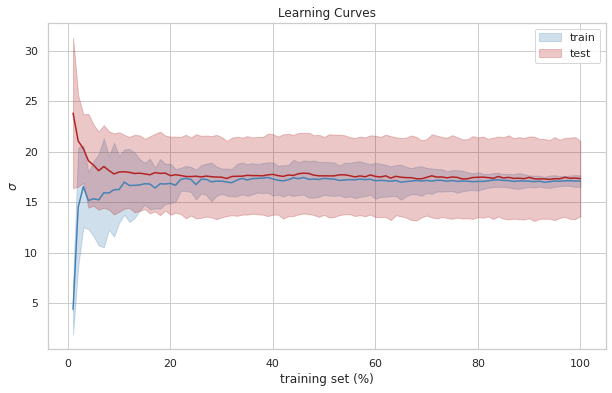

In [61]:
plot_learning_curves(lc_result, r"$\sigma$")

Based on the learning curves, the train and test curves are appear well converged, so more data will not improve the model. However, it may be helpful to "zoom" in before making any conclusions. 

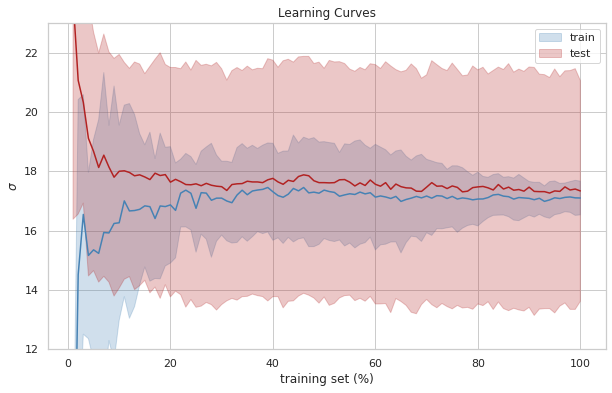

In [62]:
plot_learning_curves(lc_result, r"$\sigma$", zoom=True)

We don't seem to be dealing with a high variance situation, if the difference between the curves is not significant for our *application*. I do not think a less than 1% difference in error rate is very significant, so we can say we are not dealing with high variance. 

Is the error rate tolerable? Based on where the train and test curves converge, we can expect our model to have an error rate around 17%. In other words, the train and test curves converge where the accuracy of the model is around 83%. Determining if this is high bias depends on if we can live with that error. The main issue with our model is that it can efficiently identify true negatives but only predicts true positives *half the time*. If that is an issue for our *application*, we would say we are dealing with a high bias situation since this level of error for our model is significant. If we deem that the error is not significant, or we only care about identifying patients that will survived, then we are not dealing with a high bias situation. Lastly, if we refer back to the null model, the error rate was 76%. In comparison to the null model, we are not dealing with a high bias scenario.

<a id="4"></a>
## Describe the Final Linear Model

[Back to Contents](#00)

We can define our final model as follows:

$
\begin{align}
P(\hat{death}=1) = logistic^{-1}(\beta_0 + & \beta_1 age + \beta_2 chd + \beta_3 copd + \beta_4 cns + \beta_5 renal + \beta_6 stroke + \beta_7 OSat + \beta_8 map + \beta_9 dimer  \\
+ & \beta_{10} + platelets + \beta_{11} creatinine + \beta_{12} sodium + \beta_{13} ast~alt + \beta_{14} c~reactive~protein \\
+ & \beta_{15} procalcitonin + \beta_{16} tropinin + \beta_{17} length~of~stay + \beta_{18} creatinine:renal) \\
\end{align}
$

We can use the divide by four rule, which is implemented in the bootstrap logistic function, to interpret the coefficients.

In [63]:
models.describe_bootstrap_lgr(final, sd=4)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.0033,-0.0099,0.0132,0.5008
age,$\beta_{1}$,0.0467,0.0397,0.0543,0.0117
congestive_heart_disease,$\beta_{2}$,0.0066,-0.0640,0.0770,0.0017
chronic_obstructive_pulmonary_disease,$\beta_{3}$,0.0213,-0.0333,0.0685,0.0053
all_central_nervous_system_disease,$\beta_{4}$,0.1011,0.0112,0.1852,0.0253
renal_disease,$\beta_{5}$,0.1113,0.0190,0.2658,0.0278
stroke,$\beta_{6}$,0.0497,-0.0002,0.1005,0.0124
oxygen_saturation,$\beta_{7}$,-0.0399,-0.0494,-0.0317,-0.0100
mean_arterial_pressure,$\beta_{8}$,-0.0424,-0.0493,-0.0372,-0.0106


- $\beta_1$: For every one year increase in a patients age, the *log odds* of death increases by 0.0467. The coefficient sign is *expected* and is strongly supported by the 95% BCI. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 1.17 percentage points for each year increase. 

- $\beta_2$: When a patient has congestive heart disease, the *log odds* of death increases by 0.0066. The coefficient sign is *expected* and has mixed support from the data based on the 95% credible interval. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.17 percentage points when a patient has congestive heart disease. 

- $\beta_3$: When a patient has COPD, the *log odds* of death increases by 0.0213. The coefficient sign is *expected* and has mixed support from the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.53 percentage points when a patient has chronic obstructive pulmonary disease. 

- $\beta_4$: When a patient has a CNS disease, the *log odds* of death increases by 0.1011. The coefficient sign is *expected* and has strong support from the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 2.53 percentage points when a patient has a central nervous system disease.

- $\beta_5$: When a patient has renal disease, and the creatinine level is unchanged, the *log odds* of death increases by 0.1113. The coefficient sign is *expected* and is strongly supported by the 95% BCI. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 2.78 percentage points when a patient has a renal disease, and the creatinine level is unchanged or at "zero". 

- $\beta_6$: When a patient has had a stroke, the *log odds* of death increases by 0.0497. The coefficient sign is *expected* and has strong support from the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 1.24 percentage points when a patient has a stroke.

- $\beta_7$: When the oxygen saturation increases by one unit, the *log odds* of death decreases by -0.0399. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, decreases by 1.00 percentage points for each unit increase in oxygen saturation.

- $\beta_8$: For every one unit increase in MAP, the *log odds* of death decreases by -0.0424. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, decreases by 1.06 percentage points for each unit increase in mean arterial pressure. 

- $\beta_9$: For every one unit increase in the D-dimer level, the *log odds* of death increases by 0.0104. The coefficient sign is *expected* and has mixed support from the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.26 percentage points for each unit increase in D-dimer level.

- $\beta_{10}$: For every one unit increase in the platelet counts, the *log odds* of death decrease by -0.0017. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, decreases by 0.04 percentage points for each unit increase in D-dimer level.

- $\beta_{11}$: For every 1% increase in the creatinine level, when the patient does not have renal disease, the *log odds* of death increases by 0.2919. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 7.30 percentage points for every 1% increase in creatinine level, when the patient does not have renal disease.

- $\beta_{12}$: For every one unit increase in the sodium level, the *log odds* of death increases by 0.0147. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.37 percentage points for every one unit increase in sodium.

- $\beta_{13}$: For every one unit increase in the AST_ALT ratio, the *log odds* of death increases by 0.2542. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 6.35 percentage points for every one unit increase in the AST_ALT ratio.

- $\beta_{14}$: For every one unit increase in the c-reactive protein level, the *log odds* of death increases by 0.0206. The coefficient sign is *expected* and is strongly supported by the data, based on the 95% BCI. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.52 percentage points for every one unit increase in the C-reactive protein level.

- $\beta_{15}$: For every one unit increase in the procalcitonin level, the *log odds* of death increases by 0.0225. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.56 percentage points for every one unit increase in the procalcitonin level.

- $\beta_{16}$: For every one unit increase in the troponin_sqaured level, the *log odds* of death increases by 0.2972. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 7.43 percentage points for every one unit increase in the troponin_squared level.

- $\beta_{17}$: For every addition day that a patient stays in the hospital for Covid-19, the *log odds* of death increases by 0.0357. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 0.89 percentage points for every additional day that a patient is in the hospital.

- $\beta_{18}$: For every 1% increase in the creatinine level, when the patient has renal disease, the *log odds* of death increases by 0.1719. The coefficient sign is *expected* and is strongly supported by the data. Using the *divide by four* rule, the probability of death, or $P(death = 1)$, increases by 4.30 percentage points for every 1% increase in creatinine level, when the patient has renal disease.

One of the machine learning techniques we used to evaluate the model was K-Fold Cross validation. First, we found that the mean error rate was 17.23% and the 95% BCI for the mean error rate was 16.70% to 17.67%, given the data and the priors. Second, we found that the mean Efron's $R^2$ was 0.31 and the 95% BCI for the mean Efron's $R^2$ was 0.29 to 0.32, given the data and the priors. These mean metrics and their corresponding intervals indicate the *average performance* that could be expected when using the linear model. 

The second machine learning technique used was learning curves. Based on the results, we are not dealing with a high variance scenario, since the test and train curves were pretty well converged. We may or may not be dealing with a high bias situation, depending on the accuracy needed for our *application*. Compared to the null model, which had an error rate of 76%, we have significantly improved our accuracy with the logistic regression model. Therefore, I would consider our error *manageable*, which means we are not dealing with a high bias scenario. Therefore, our model is neither under or overfitting, based on the learning curves. 

<a id="5"></a>
## Using the Linear Model

[Back to Contents](#00)

For each prediction, we will refer back to our null model for comparison:

```
P(death = 0) = 0.76
P(death = 1) = 0.24 
```

***Let's say we have a 64 year old patient who has COPD and the following physical and blood panel results:***

- OSat: 91%
- MAP: 80 mm Hg
- D-Dimer: 3.5 u/mL
- platelets: 210 platelets/uL
- creatinine: 1.9 mg/dL
- sodium: 140 mEq/L
- AST/ALT: 1.5
- c-reactive protein: 8 mg/dL
- procalcitonin: 1.3 ng/mL
- troponin: 0.06 ng/mL
- length of stay: 14 days

We would expect this patient to survive, since most of their blood panel results are low compared to the mean levels found in patients who died from Covid-19.

In [64]:
pred1 = [1, 64, 0, 1, 0, 0, 0, 91, 80, 3.5, 210, np.log(1.9), 140, 1.5, 8, 1.3, (0.06 ** 2), 14, (np.log(1.9) * 0)]
prediction1 = final["model"].predict([pred1])
prob1 = final["model"].predict_proba([pred1])
print(f"Patient outcome: {prediction1[0]}")
print(f"P(death = 0): {prob1[0][0]}")
print(f"P(death = 1): {prob1[0][1]}")

Patient outcome: 0.0
P(death = 0): 0.7350188540488497
P(death = 1): 0.2649811459511503


Our model would classify this patient as *alive*, meaning they survived Covid-19, as we expected. If we refer to the probabilities, our model determined that there is a 73.50% chance that this patient would survive. In this case, our null model would have had a higher probability that the patient would have survived, at 76%. 


***Let's say we have a 40 year old patient who has renal disease and the following physical and blood panel results:***

- OSat: 82%
- MAP: 60 mm Hg
- D-Dimer: 5.1 u/mL
- platelets: 170 platelets/uL
- creatinine: 4.3 mg/dL
- sodium: 150 mEq/L
- AST/ALT: 1.8
- c-reactive protein: 17 mg/dL
- procalcitonin: 3.1 ng/mL
- troponin: 1.8 ng/mL
- length of stay: 8 days

We would expect this patient to die from Covid-19, since they present results aligning with severe kidney dysfunction and poor blood circulation in addition to their pre-existing renal disease. In addition, they show signs of heart muscle damage due to the elevated levels of troponin. 

In [65]:
pred2 = [1, 40, 0, 0, 0, 1, 0, 82, 60, 5.1, 170, np.log(4.3), 150, 1.8, 17, 3.1, (1.8 ** 2), 8, (np.log(17) * 1)]
prediction2 = final["model"].predict([pred2])
prob2 = final["model"].predict_proba([pred2])
print(f"Patient outcome: {prediction2[0]}")
print(f"P(death = 0): {prob2[0][0]}")
print(f"P(death = 1): {prob2[0][1]}")

Patient outcome: 1.0
P(death = 0): 0.23802369858493144
P(death = 1): 0.7619763014150686


As expected, this patient would have a poor outcome from Covid-19 since our model indicated that they would *not survive*. The model determined that there is a 76.20% chance that this patient would die as a result of Covid-19. Our null model would have only given a 27% probability that the patient died from Covid-19. Therefore, in cases where we may want to predict poor patient outcomes, our linear model performs much better.

The patient stats we used in this prediction are more "obvious", even though the patient is younger. What if the patient is the same age and presents signs of inflammation and blood circulation dysfunction as a direct result of Covid-19, but no other signs related to organ dysfunction or pre-existing conditions? 

***Let's say we have a 40 year old patient with no pre-existing conditions and the following physical and blood panel results***

- OSat: 82%
- MAP: 57 mm Hg
- D-Dimer: 5.0 u/mL
- platelets: 200 platelets/uL
- creatinine: 1.5 mg/dL
- sodium: 130 mEq/L
- AST/ALT: 0.5
- c-reactive protein: 17 mg/dL
- procalcitonin: 3.0 ng/mL
- troponin: 2 ng/mL
- length of stay: 8 days

This patient has very obvious signs of severe infection and poor blood circulation, so we would expect this patient to have a poor outcome from Covid-19. However, will the model determine the same if no pre-existing conditions or related blood panel results are present?

In [66]:
pred3 = [1, 40, 0, 0, 0, 0, 0, 82, 57, 5.0, 200, np.log(1.0), 130, 0.5, 20, 3.0, (2 ** 2), 8, (np.log(1) * 0)]
prediction3 = final["model"].predict([pred3])
prob3 = final["model"].predict_proba([pred3])
print(f"Patient outcome: {prediction3[0]}")
print(f"P(death = 0): {prob3[0][0]}")
print(f"P(death = 1): {prob3[0][1]}")

Patient outcome: 0.0
P(death = 0): 0.531181434485827
P(death = 1): 0.468818565514173


This is likely a case where our model may generate a *false negative*. This patient presents clear signs of severe infection with elevated procalcitonin and c-reactive protein levels, as well as low blood oxygen saturation and low mean arterial pressure which are typical in hospitalized Covid-19 patients. Therefore, we might expect that this patient would not survive. The model predicts that the patient would survive, but when we look at the probabilities, we see almost a 50/50 chance that the patient survives or dies. In cases like this, the model is not able to determine if the patient will survive because the patient has severe symptoms but no organ dysfunction or pre-existing condition. Our null model would have predicted that the patient would have survived, as well, and the null model states that there is a 76% chance that the patient would survive. Since this seems more like a case where the patient may have not survived, the linear model likely performs better. 

Just like we saw during the pandemic, some patients pass away even though they are young with no pre-existing conditions or major organ dysfunction. Even our model is unable to confidently say whether patients with these characteristics will survive. We can try to categorize people based on high or low risk when it comes to Covid-19, but as our model has shown, sometimes treating everyone like they are high risk is safer. 